In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt

import warnings
import scipy
import scanpy as sc



# HOTSPOT

In [5]:
#preparing raw tumor data 

row_cells = sc.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/10Samples_agg_gex_raw.h5ad")

tumor= sc.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/Tumor_after_check_atac.h5ad")
import scanpy as sc

# get cell names from tumor data
tumor_cells = tumor.obs_names

# subset row_cells to only include cells that are in tumor data
row_cells_tumor2 = row_cells[row_cells.obs_names.isin(tumor_cells)].copy()


In [6]:
adata = row_cells_tumor2

In [7]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'site', 'patient', 'patientzone', 'source'

In [8]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [9]:
sc.pp.filter_genes(adata , min_counts= 5)

In [10]:
adata.layers["counts"] = adata.X.copy()

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.02, max_mean=4, min_disp=0.5)
adata.layers["log_normalized"] = adata.X.copy()
sc.pp.scale(adata)
sc.tl.pca(adata)

In [12]:
import hotspot

hs = hotspot.Hotspot(
    adata,
    layer_key="counts",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)


/home/fatemeh.nasrabadi/anaconda3/envs/new_scenv/lib/python3.11/site-packages/hotspot/hotspot.py:98: UserWarning: Hotspot will work faster when counts are a csr sparse matrix.
  warnings.warn(


In [13]:
hs

In [14]:
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)

In [15]:
hs_results = hs.compute_autocorrelations()

100%|██████████| 27494/27494 [07:55<00:00, 57.83it/s]


In [16]:
hs_results

C            Z      Pval       FDR
Gene                                                 
AC009041.2  0.478881  1754.467576  0.000000  0.000000
MTRNR2L12   0.277726  1077.020998  0.000000  0.000000
PDGFRA      0.538719   948.853265  0.000000  0.000000
MALAT1      0.572337   843.458831  0.000000  0.000000
VEGFA       0.505016   793.901227  0.000000  0.000000
...              ...          ...       ...       ...
AC069224.1 -0.003835    -2.218099  0.986726  0.986870
AP000692.1 -0.004358    -2.225602  0.986980  0.987087
RBM44      -0.004473    -2.345562  0.990501  0.990573
AC011444.1 -0.005035    -2.432558  0.992504  0.992540
AL356512.1 -0.003359    -2.840651  0.997749  0.997749

[27494 rows x 4 columns]

In [17]:
# 1) HVG set (from the same AnnData you used for Hotspot)
hvg_genes = adata.var_names[adata.var['highly_variable']]

In [18]:
hvg_genes 

Index(['KLHL17', 'HES4', 'ISG15', 'AGRN', 'SDF4', 'SCNN1D', 'ACAP3', 'INTS11',
       'DVL1', 'MXRA8',
       ...
       'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L',
       'MT-ND4', 'MT-ND5', 'MT-CYB'],
      dtype='object', length=3217)

In [19]:
# 2) Significant Hotspot genes
sig = hs_results.query('FDR < 0.05').sort_values('Z', ascending=False)

# 3) Keep only genes that are BOTH significant and HVG
sig_hvg = sig.loc[sig.index.intersection(hvg_genes)]

# 4) Take top 500 (or all if fewer)
top_n = min(3000, sig_hvg.shape[0])
hs_genes = sig_hvg.index[:top_n]

print(f"Using {top_n} genes (sig ∩ HVG).")

# 5) Pairwise local correlations on this HVG-restricted set
lcz = hs.compute_local_correlations(hs_genes, jobs=4)


Using 3000 genes (sig ∩ HVG).
Computing pair-wise local correlation on 3000 features...


100%|██████████| 4498500/4498500 [16:52<00:00, 4442.27it/s]


In [20]:
hs_genes

Index(['AC009041.2', 'MTRNR2L12', 'PDGFRA', 'VEGFA', 'SEC61G', 'PLCG2',
       'AC110285.1', 'AL359091.1', 'LINC02283', 'DLX6-AS1',
       ...
       'CASP3', 'AC060765.2', 'BLOC1S2', 'AC116362.1', 'YIPF5', 'PCDHA10',
       'PSMC5', 'PMM1', 'GDE1', 'P3H4'],
      dtype='object', length=3000)

In [21]:
lcz

AC009041.2  MTRNR2L12     PDGFRA      VEGFA     SEC61G      PLCG2  \
AC009041.2    0.000000  -3.846811  36.094564 -16.994455 -11.260815 -18.965120   
MTRNR2L12    -3.846811   0.000000  -2.423091  16.483465  27.459938  33.760524   
PDGFRA       36.094564  -2.423091   0.000000 -11.214775  -6.549447  -1.865023   
VEGFA       -16.994455  16.483465 -11.214775   0.000000  76.642248  72.142658   
SEC61G      -11.260815  27.459938  -6.549447  76.642248   0.000000  87.761117   
...                ...        ...        ...        ...        ...        ...   
PCDHA10       1.941061   2.517802  -0.415137   2.272241   3.163912   0.772058   
PSMC5         2.151381   0.135781   3.095730  -3.875597  -1.042135  -3.155731   
PMM1          0.238442   3.686805  -0.407091  -0.866404  -0.990343  -1.602396   
GDE1          1.069771   1.844103   2.745782  -2.285890  -1.145571  -0.597416   
P3H4         -0.324265  -0.682799   2.754125  -2.733210  -2.507397  -0.441349   

            AC110285.1  AL359091.1  LINC02283  DLX6-AS1  ...     CASP3  \
AC009041.2   54.824559   74.477564  30.445980  7.206724  ... -2.253223   
MTRNR2L12    -3.454082   -3.768952  -4.715790  0.534022  ... -1.149563   
PDGFRA        9.385350   13.895556  70.268371 -1.151411  ... -0.828348   
VEGFA       -14.705858  -17.342236  -9.981104 -3.843305  ... -1.902085   
SEC61G      -10.392713  -13.604176 -11.153544  0.365393  ... -1.799024   
...                ...         ...        ...       ...  ...       ...   
PCDHA10       0.973885   -0.258230  -1.709968  4.920079  ... -2.507921   
PSMC5         2.020104    2.663223   3.796525 -0.302585  ...  1.432516   
PMM1         -0.077819    0.882626   0.935264  0.307171  ...  0.803404   
GDE1          1.647271    3.216669   2.726937 -0.053848  ...  2.840362   
P3H4         -1.193701   -1.284788   2.489186 -1.215435  ...  1.325772   

            AC060765.2   BLOC1S2  AC116362.1     YIPF5   PCDHA10     PSMC5  \
AC009041.2    0.138233 -0.815438    0.191549  1.141295  1.941061  2.151381   
MTRNR2L12     4.023973  0.399200    1.922201  1.701414  2.517802  0.135781   
PDGFRA        2.065628 -1.210861    0.684875  1.355894 -0.415137  3.095730   
VEGFA         3.040030  0.678717    0.967823  3.116780  2.272241 -3.875597   
SEC61G        2.655894  0.055016    2.025168  3.239093  3.163912 -1.042135   
...                ...       ...         ...       ...       ...       ...   
PCDHA10       0.012923 -2.798517    1.622142 -0.885503  0.000000 -1.005176   
PSMC5        -0.476008  2.080532   -0.692625  1.734292 -1.005176  0.000000   
PMM1         -0.037008  3.246464    0.301530 -1.634370  0.072226  3.662029   
GDE1          1.573235  3.099756    0.104580  2.605274 -1.339576  5.996994   
P3H4          1.559617 -0.442472   -0.176497  1.438661 -2.971957  3.417285   

                PMM1      GDE1      P3H4  
AC009041.2  0.238442  1.069771 -0.324265  
MTRNR2L12   3.686805  1.844103 -0.682799  
PDGFRA     -0.407091  2.745782  2.754125  
VEGFA      -0.866404 -2.285890 -2.733210  
SEC61G     -0.990343 -1.145571 -2.507397  
...              ...       ...       ...  
PCDHA10     0.072226 -1.339576 -2.971957  
PSMC5       3.662029  5.996994  3.417285  
PMM1        0.000000  4.512891  1.288352  
GDE1        4.512891  0.000000  1.508121  
P3H4        1.288352  1.508121  0.000000  

[3000 rows x 3000 columns]

In [22]:
modules = hs.create_modules(
    min_gene_threshold=40, core_only=True, fdr_threshold=0.05
)

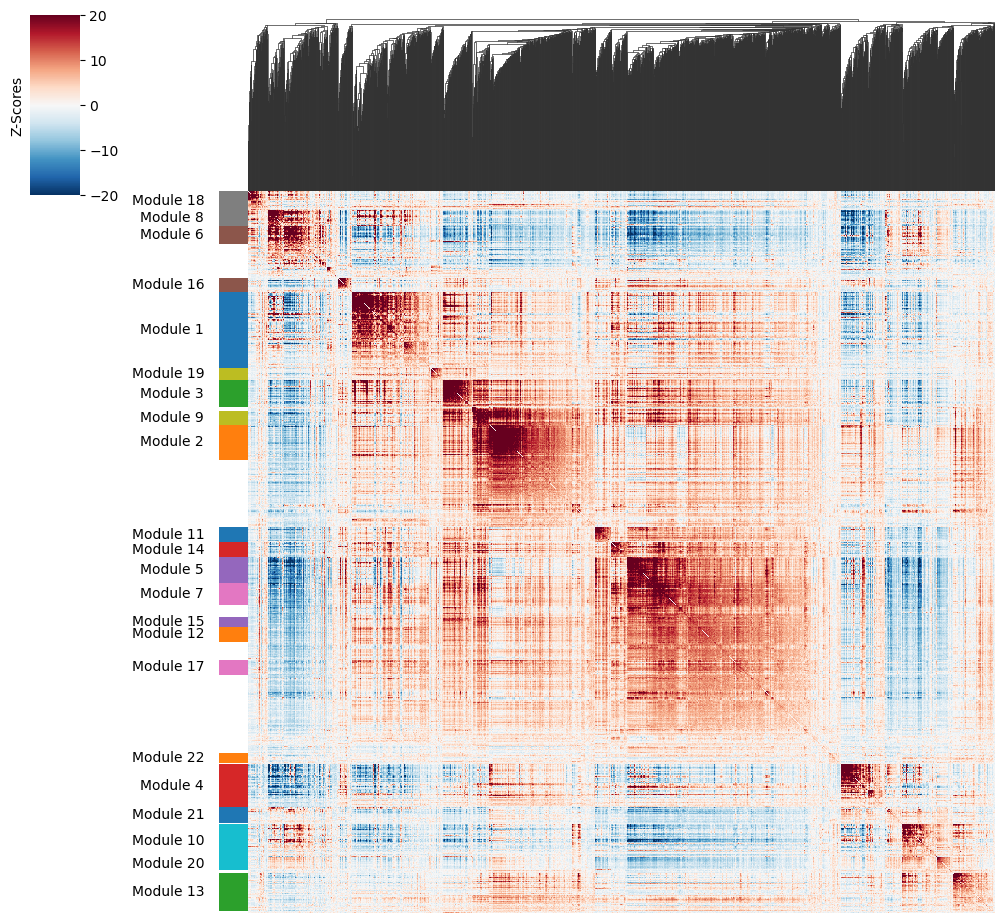

In [23]:
hs.plot_local_correlations(vmin=-20, vmax=20,)

In [24]:
!pwd

/home/fatemeh.nasrabadi/THESIS_GBH_filtered/5_GEX_HOTSPOT_LIANA


# Save

In [ ]:
# to save 
for module in range(1, 21):  # range should include 8 as well
    # Merge results and module assignments
    results = hs.results.join(hs.modules)

    # Filter genes for this module
    results_module = results[results['Module'] == module]

    # Sort by Z score (optional, for readability)
    results_module = results_module.sort_values('Z', ascending=False)

    # Save all genes in the module to CSV
    results_module.to_csv(f"hotspot_file/hotspot_module_{module}.csv")


In [26]:
# 
for module in range(1, 21):  # include 8
    # Merge results and module assignments
    results = hs.results.join(hs.modules)

    # Filter genes for this module
    results_module = results[results['Module'] == module]

    # Sort by Z score (optional)
    results_module = results_module.sort_values('Z', ascending=False)

    # Print header for clarity
    print(f"\n=== Module {module} ===")

    # Print each gene name (assuming the index holds gene names)
    for gene in results_module.index:
        print(gene)


=== Module 1 ===
AC009041.2
PDGFRA
AC110285.1
AL359091.1
LINC02283
DLX6-AS1
CADM2
SOX6
TNR
DSCAM
SCN3A
FGF12
BCAN
GALNT13
OLIG1
BCAS1
OPCML
MARCH1
NNAT
GPR17
DLL3
MYRF
AATK
KCNS3
PCDH15
SMOC1
BMPER
LRRTM4
FERMT1
SIRT2
AL512308.1
GRIK2
PKP4
EPB41L2
LRRC4C
DSCAML1
DGKB
FRMD4A
TNS3
SNX22
TNK2
P2RX7
ZNF536
COL20A1
ACAP3
NTM
SLC44A1
ADAM33
TMEFF2
OPHN1
PPP1R16B
PHACTR3
LSAMP
CA10
IL1RAPL1
MDGA2
CNTN1
TMEM108
PTPRS
FRMD5
EPHB1
DNM3
GRIA4
AC004852.2
PCDH7
SCD5
CACNA1A
MEGF11
TMEM132B
DOCK10
DLG1
KAZN
HES6
LCNL1
ENPP6
LINC01170
PLPPR1
ZEB2
SLC16A10
RASGEF1B
AC060834.2
VIPR2
AL355306.2
LUZP2
SGK1
KLRC2
SEMA5B
AC006058.1
PHYHIPL
DOCK6
PLCB1
ATCAY
ALCAM
AC073365.1
DNER
KIF21B
ERBB3
SHD
SOX8
SRCIN1
FRMD4B
COL11A1
GPC6
TNS2
KCNH8
SOX10
CDK18
SEMA4D
KLRC3
SHANK2
RIMS1
UNC80
ANO3
EYS
UGT8
NTN1
REPS2
NKD1
CDH13
ARPP21
FAM110B
GNAI1
DLL1
NEU4
PCDH11X
NFASC
SH3RF3
KCNMB2
KHDRBS3
FOXP2
PRICKLE1
RNF144A
ASIC1
TTC9B
FBN3
MMP17
PTPRO
EYA1
LINC00599
SCG3
CELF3
CSPG5
STK32B
FXYD6
C1QL1
TMEM163
HIP1R
ADRA1A
A

In [28]:
import pickle

# Save the entire Hotspot object
with open("hotspot_ALLtumor_highlyvariablegenes.pkl", "wb") as f:
    pickle.dump(hs, f)


In [29]:
!pwd

/home/fatemeh.nasrabadi/THESIS_GBH_filtered/5_GEX_HOTSPOT_LIANA


In [ ]:
import pickle
with open("hotspot_file/hotspot_ALLtumor_highlyvariablegenes.pkl", "rb") as f:
    hotspot_obj = pickle.load(f)

In [ ]:
hotspot_obj

In [ ]:
modules = hs.create_modules(
    min_gene_threshold=40, core_only=True, fdr_threshold=0.05
)

In [ ]:
hs.plot_local_correlations(vmin=-20, vmax=20,)

In [ ]:
write_dataset(lcz, "/home/fatemeh.nasrabadi/ROVIGO_congas/final/gex_aggregation/hotspot_file/HotspotLCZ_10S_highly.tsv")

In [ ]:
## Reading the data

In [ ]:
import pickle
with open("hotspot_file/hotspot_ALLtumor_highlyvariablegenes.pkl", "rb") as f:
    hotspot_obj = pickle.load(f)

In [ ]:
module_scores = hotspot_obj.calculate_module_scores()

In [ ]:
module_scores

In [ ]:
tumor = sc.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/Tumor_row_FINAL_afteratac8121.h5ad")

In [ ]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    tumor.obs[key] = module_scores[c]
    module_cols.append(key)

In [ ]:
n = 20  # you can change this number
score_cols = [f"Module {i}" for i in range(1, n + 1)]
print(score_cols)


# Visualization

In [32]:
import pickle
with open("/home/fatemeh.nasrabadi/ROVIGO_congas/final/gex_aggregation/hotspot_file/hotspot_ALLtumor_highlyvariablegenes.pkl", "rb") as f:
    hotspot_obj = pickle.load(f)
    
hs = hotspot_obj

modules = hs.create_modules(
    min_gene_threshold=40, core_only=True, fdr_threshold=0.05
)

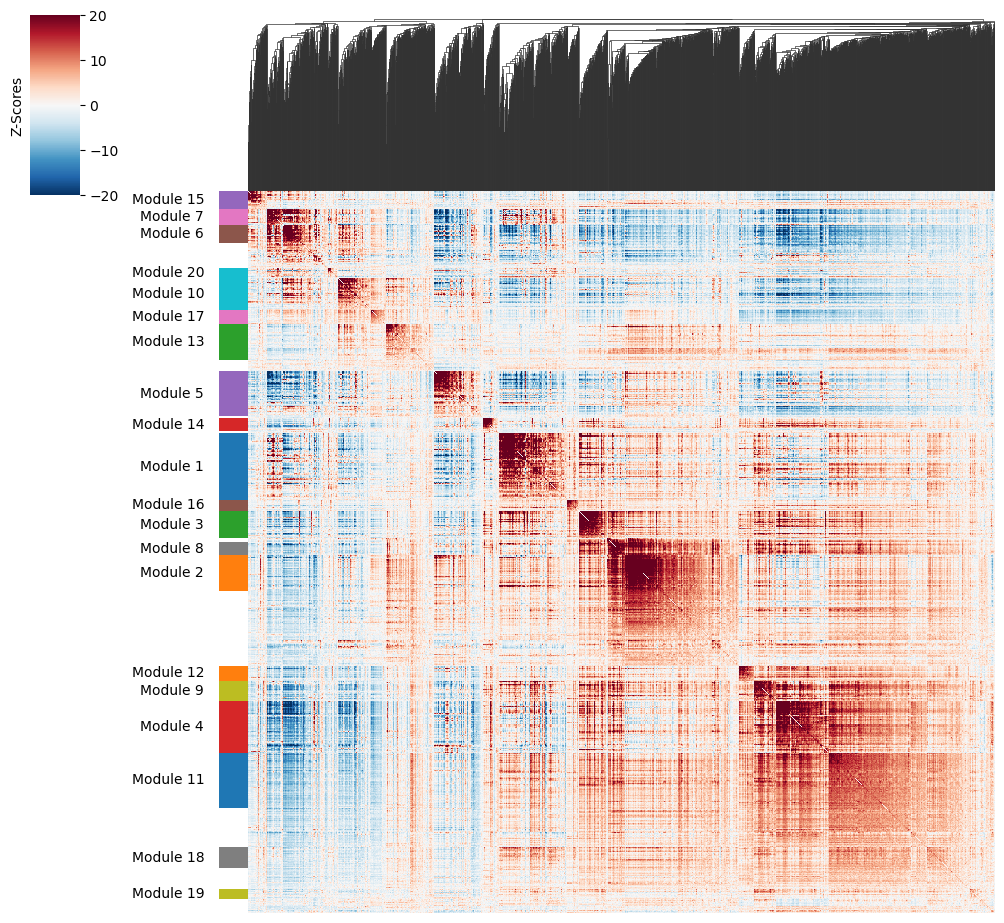

In [33]:
hs.plot_local_correlations(vmin=-20, vmax=20)

In [34]:
module_scores = hotspot_obj.calculate_module_scores() 

Computing scores for 20 modules...


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


In [35]:
module_scores

1         2          3         4   \
AATCATCCATGTGGGA-1_BTROHT06_Peri   1.443171 -3.586384  14.740740  4.512987   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  -0.743586 -4.103982   3.246444  7.304844   
AGTATAGCATTGTGTG-1_BTROHT06_Peri  41.456902 -0.827937   9.224749 -1.460960   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  -1.440168  0.558769   4.350001  2.024365   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  -1.017943 -0.874249   0.339173  0.417180   
...                                     ...       ...        ...       ...   
TTTGGTGCAAGACTCC-1_BTROHT06_Core  -3.389867  0.503556  -1.542511 -1.722948   
TTTGTCTAGAGAGCCG-1_BTROHT06_Core  -3.318490  0.698370  -1.567301 -2.315544   
TTTGTGTTCCAATTAG-1_BTROHT06_Core  -3.537334  4.006793  -1.681094 -2.239967   
TTTGTTGGTAATGACT-1_BTROHT06_Core  -3.793101  0.129752  -1.239355 -2.242564   
TTTGTTGGTTCATCTA-1_BTROHT06_Core  -3.663373  0.001234  -1.474913 -2.337040   

                                         5         6         7         8   \
AATCATCCATGTGGGA-1_BTROHT06_Peri  -1.307571 -3.384105 -3.497232  0.691517   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  -1.351591 -3.800220 -2.722257  0.270490   
AGTATAGCATTGTGTG-1_BTROHT06_Peri  -3.029989 -3.788168  0.092761 -0.816182   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  -0.815776 -2.914601 -3.879433  1.036769   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  -1.012219 -1.769768 -0.140825 -0.391529   
...                                     ...       ...       ...       ...   
TTTGGTGCAAGACTCC-1_BTROHT06_Core  13.260367 -2.650528 -3.718015 -0.700814   
TTTGTCTAGAGAGCCG-1_BTROHT06_Core  10.273483 -3.461943 -2.487255 -0.583715   
TTTGTGTTCCAATTAG-1_BTROHT06_Core  13.960736 -3.096523 -3.720568  0.190603   
TTTGTTGGTAATGACT-1_BTROHT06_Core   6.541578 -4.368190 -4.591019 -1.090116   
TTTGTTGGTTCATCTA-1_BTROHT06_Core  13.683123 -3.030527 -4.111045 -0.814033   

                                        9         10        11        12  \
AATCATCCATGTGGGA-1_BTROHT06_Peri  6.931068 -3.376321 -0.912603  0.733751   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  6.502953 -3.275091 -0.497166  0.314308   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -0.674308 -3.484411 -1.605391 -0.636608   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  0.601112 -0.320632 -0.306344  2.867759   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  0.161809 -1.636317 -0.390333  0.198644   
...                                    ...       ...       ...       ...   
TTTGGTGCAAGACTCC-1_BTROHT06_Core -1.983692 -1.668673 -2.330941 -0.895678   
TTTGTCTAGAGAGCCG-1_BTROHT06_Core -1.922721 -2.198110 -2.040259 -0.912910   
TTTGTGTTCCAATTAG-1_BTROHT06_Core -2.070015 -1.820258 -1.569508 -0.972632   
TTTGTTGGTAATGACT-1_BTROHT06_Core -2.043158 -0.695088 -1.622065 -0.932089   
TTTGTTGGTTCATCTA-1_BTROHT06_Core -1.990985  2.373430 -2.560636 -1.101601   

                                        13         14        15        16  \
AATCATCCATGTGGGA-1_BTROHT06_Peri -1.435979   0.907483 -1.930760  1.714940   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri -1.295643   0.726737 -1.782945  1.242931   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -1.128988   0.473656 -1.909679  4.471356   
ATATGCTCATCCCGCT-1_BTROHT06_Peri -0.053672  50.115695 -0.905679  0.800980   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri -0.369935  -0.132385 -0.113610  1.189091   
...                                    ...        ...       ...       ...   
TTTGGTGCAAGACTCC-1_BTROHT06_Core -0.753490   0.301914 -1.299106 -0.353545   
TTTGTCTAGAGAGCCG-1_BTROHT06_Core -0.532961  -0.477419 -1.595870 -0.563207   
TTTGTGTTCCAATTAG-1_BTROHT06_Core -0.535704  -0.425432 -1.480936 -0.409263   
TTTGTTGGTAATGACT-1_BTROHT06_Core -0.080810   0.137547 -1.545343 -0.190086   
TTTGTTGGTTCATCTA-1_BTROHT06_Core -0.866875  -0.044790 -1.882291 -0.446471   

                                        17        18        19        20  
AATCATCCATGTGGGA-1_BTROHT06_Peri  2.659619 -0.966756  6.388129 -0.647587  
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  3.520266 -0.799885  8.062720 -0.103738  
AGTATAGCATTGTGTG-1_BTROHT06_Peri  0.120682 -0.187647  0.306922 -0.400448  
ATATGCTCATCCCGCT-1_BTROHT06_Peri  0.88038

In [36]:
# --- MODULE TITLES + TOP GENES (keyed by module number) ---
module_names = {
    1:  "Neuronal system\n(OLIG2, SOX10, GPR17, SHANK2)",
    2:  "Oxidative phosphorylation\n(RPL11, RPS6, EEF1A1, EIF1)",
    3:  "CNS myelination\n(PLP1, MBP, MOG, MOBP)",
    4:  "ECM / Collagen binding\n(COL4A6, COL5A3, ITGA2, DDR1)",
    5:  "ECM degradation\n(ADAMTS1, ADAMTS9, COL4A1, CD44)",
    6:  "Cell–cell junctions\n(PCDH9, EPHA4, CDH8, PTPRD)",
    7:  "EGFR-driven GBM\n(EGFR, PTPRZ1, VCAN, SOX4)",
    8:  "AC-like\n(APOE, AQP4, S100B, GJA1)",
    9:  "Cytoskeletal cleavage\n(GFAP, NTRK2, SLC6A1, ALDH1L1)",
    10: "Hypoxia & angiogenesis\n(VEGFA, EPAS1, PDK1, CA12)",
    11: "AP-type trafficking\n(AP3D1, FLNA, KIF5A, TEPSIN)",
    12: "Immune response\n(SPP1, CD163, HLA-DRA, APOC1)",
    13: "Chaperone-mediated folding\n(HSP90AA1, HSPA1A, HSPD1, STIP1)",
    14: "ECM organization\n(FN1, COL1A2, LAMB1, THBS1)",
    15: "Cell cycle\n(TOP2A, CCNB1, AURKB, CDC20)",
    16: "Ion transport regulation\n(GRIN2A, CACNA1E, SYT1, CNTNAP2)",
    17: "Regulatory / non-coding\n(NEUROD1, ESRP1, PPARG, SSTR2)",
    18: "Neuronal stress & trafficking\n(STX1B, THY1, UNC119, SNAPIN)",
    19: "Neuronal signaling\n(ASTN2, NT5E, TRPV1, SLC6A11)",
    20: "Neuronal differentiation\n(SOX11, MYT1L, RBFOX3, EPHA7)"
}


In [37]:
#then i updated to the following list

In [38]:
# --- MODULE TITLES + TOP GENES (keyed by module number) ---
module_names = {
    1:  "Neuronal system\n(OLIG2, SOX10, GPR17, SHANK2)",
    2:  "Oxidative phosphorylation\n(RPL11, RPS6, EEF1A1, EIF1)",
    3:  "CNS myelination\n(PLP1, MBP, MOG, MOBP)",
    4:  "ECM / Collagen binding\n(COL4A6, COL5A3, ITGA2, DDR1)",
    5:  "ECM degradation\n(ADAMTS1, ADAMTS9, COL4A1, CD44)",
    6:  "Cell–cell junctions\n(PCDH9, EPHA4, CDH8, PTPRD)",
    7:  "EGFR-driven GBM\n(EGFR, PTPRZ1, VCAN, SOX4)",
    8:  "AC-like\n(APOE, AQP4, S100B, GJA1)",
    9:  "Cytoskeletal cleavage\n(GFAP, NTRK2, SLC6A1, ALDH1L1)",
    10: "Hypoxia & angiogenesis\n(VEGFA, EPAS1, PDK1, CA12)",
    11: "AP-type trafficking\n(AP3D1, FLNA, KIF5A, TEPSIN)",
    12: "Immune response\n(SPP1, CD163, HLA-DRA, APOC1)",
    13: "Chaperone-mediated folding\n(HSP90AA1, HSPA1A, HSPD1, STIP1)",
    14: "ECM organization\n(FN1, COL1A2, LAMB1, THBS1)",
    15: "Cell cycle\n(TOP2A, CCNB1, AURKB, CDC20)",
    16: "Ion transport regulation\n(GRIN2A, CACNA1E, SYT1, CNTNAP2)",
    17: "Regulatory / non-coding\n(NEUROD1, ESRP1, PPARG, SSTR2)",
    18: "Neuronal stress & trafficking\n(STX1B, THY1, UNC119, SNAPIN)",
    19: "Neuronal signaling\n(ASTN2, NT5E, TRPV1, SLC6A11)",
    20: "brain-specific lncRNAs\n(MIAT, MAPT-AS1, ZEB1-AS1, NFIA-AS2)"
}


In [40]:
#then again i updated to this 

In [41]:
module_names = {
    1:  "Neuronal system\n(OLIG2, SOX10, GPR17, SHANK2)",
    2:  "Translation\n(RPL11, RPS6, EEF1A1, EIF1)",
    3:  "CNS myelination\n(PLP1, MBP, MOG, MOBP)",
    4:  "ECM / Collagen binding\n(COL4A6, COL5A3, ITGA2, DDR1)",
    5:  "Inflammatory reactive tissue response\n(CHI3L1, OSMR, THBS2, GDF15)",
    6:  "Cell–cell junctions\n(PCDH9, EPHA4, CDH8, PTPRD)",
    7:  "EGFR-driven GBM\n(EGFR, PTPRZ1, VCAN, SOX4)",
    8:  "AC-like 1\n(AQP4, S100B, GJA1)",
    9:  "AC-like 2\n(GFAP, ALDH1L1, NTRK2)",
    10: "Hypoxia & angiogenesis\n(VEGFA, EPAS1, PDK1, CA12)",
    11: "Protein trafficking\n(AP3D1, FLNA, KIF5A, TEPSIN)",
    12: "Immune-related\n(HLA-DRA, CD74, ADGRE5, ARHGAP24)",
    13: "Chaperone-mediated folding\n(HSP90AA1, HSPA1A, HSPD1, STIP1)",
    14: "Structural fibroblast/pericyte ECM\n(COL1A2, FN1, LAMA2, TIMP3)",
    15: "Cell cycle\n(TOP2A, CCNB1, AURKB, CDC20)",
    16: "Neuronal synaptic signaling\n(GRIN2A, CACNA1E, SYT1, CNTNAP2)",
    17: "Regulatory / non-coding\n(NEUROD1, ESRP1, PPARG, SSTR2)",
    18: "Neuronal stress & trafficking\n(STX1B, THY1, UNC119, SNAPIN)",
    19: "Neuronal signaling\n(ASTN2, TRPV1, SLC6A11)",
    20: "brain-specific lncRNAs\n(MIAT, MAPT-AS1, ZEB1-AS1, NFIA-AS2)"
}


In [42]:
module_names = {
    1:  "Neuronal system",
    2:  "Translation",
    3:  "CNS myelination",
    4:  "ECM / Collagen binding",
    5:  "Inflammatory response",
    6:  "Cell–cell junctions",
    7:  "EGFR-driven GBM",
    8:  "AC-like 1",
    9:  "AC-like 2",
    10: "Hypoxia & angiogenesis",
    11: "Protein trafficking",
    12: "Immune-related",
    13: "Chaperone-mediated folding",
    14: "ECM organization and structure",
    15: "Cell cycle",
    16: "Neuronal synaptic signaling",
    17: "Non-coding RNAs",
    18: "Neuronal stress & trafficking",
    19: "Neuronal signaling",
    20: "Brain-specific lncRNAs"
}


Using module columns (original order): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Plotting modules in this order: [1, 3, 8, 9, 16, 18, 19, 15, 7, 6, 14, 4, 5, 2, 10, 11, 13, 12, 17, 20]


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 9.44e-170 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 9.89e-271 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.96e-183 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 5.08e-195 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 4.02e-166 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 8.36e-127 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.42e-210 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.09e-12 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.95e-20 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 5.70e-126 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 3.89e-138 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 9.75e-132 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 5.10e-01 


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 8.54e-90 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.02e-143 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 2.41e-131 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.52e-42 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 4.52e-89 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 2.35e-09 *


/tmp/ipykernel_598157/2090968118.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. Peri: FDR = 1.69e-01 


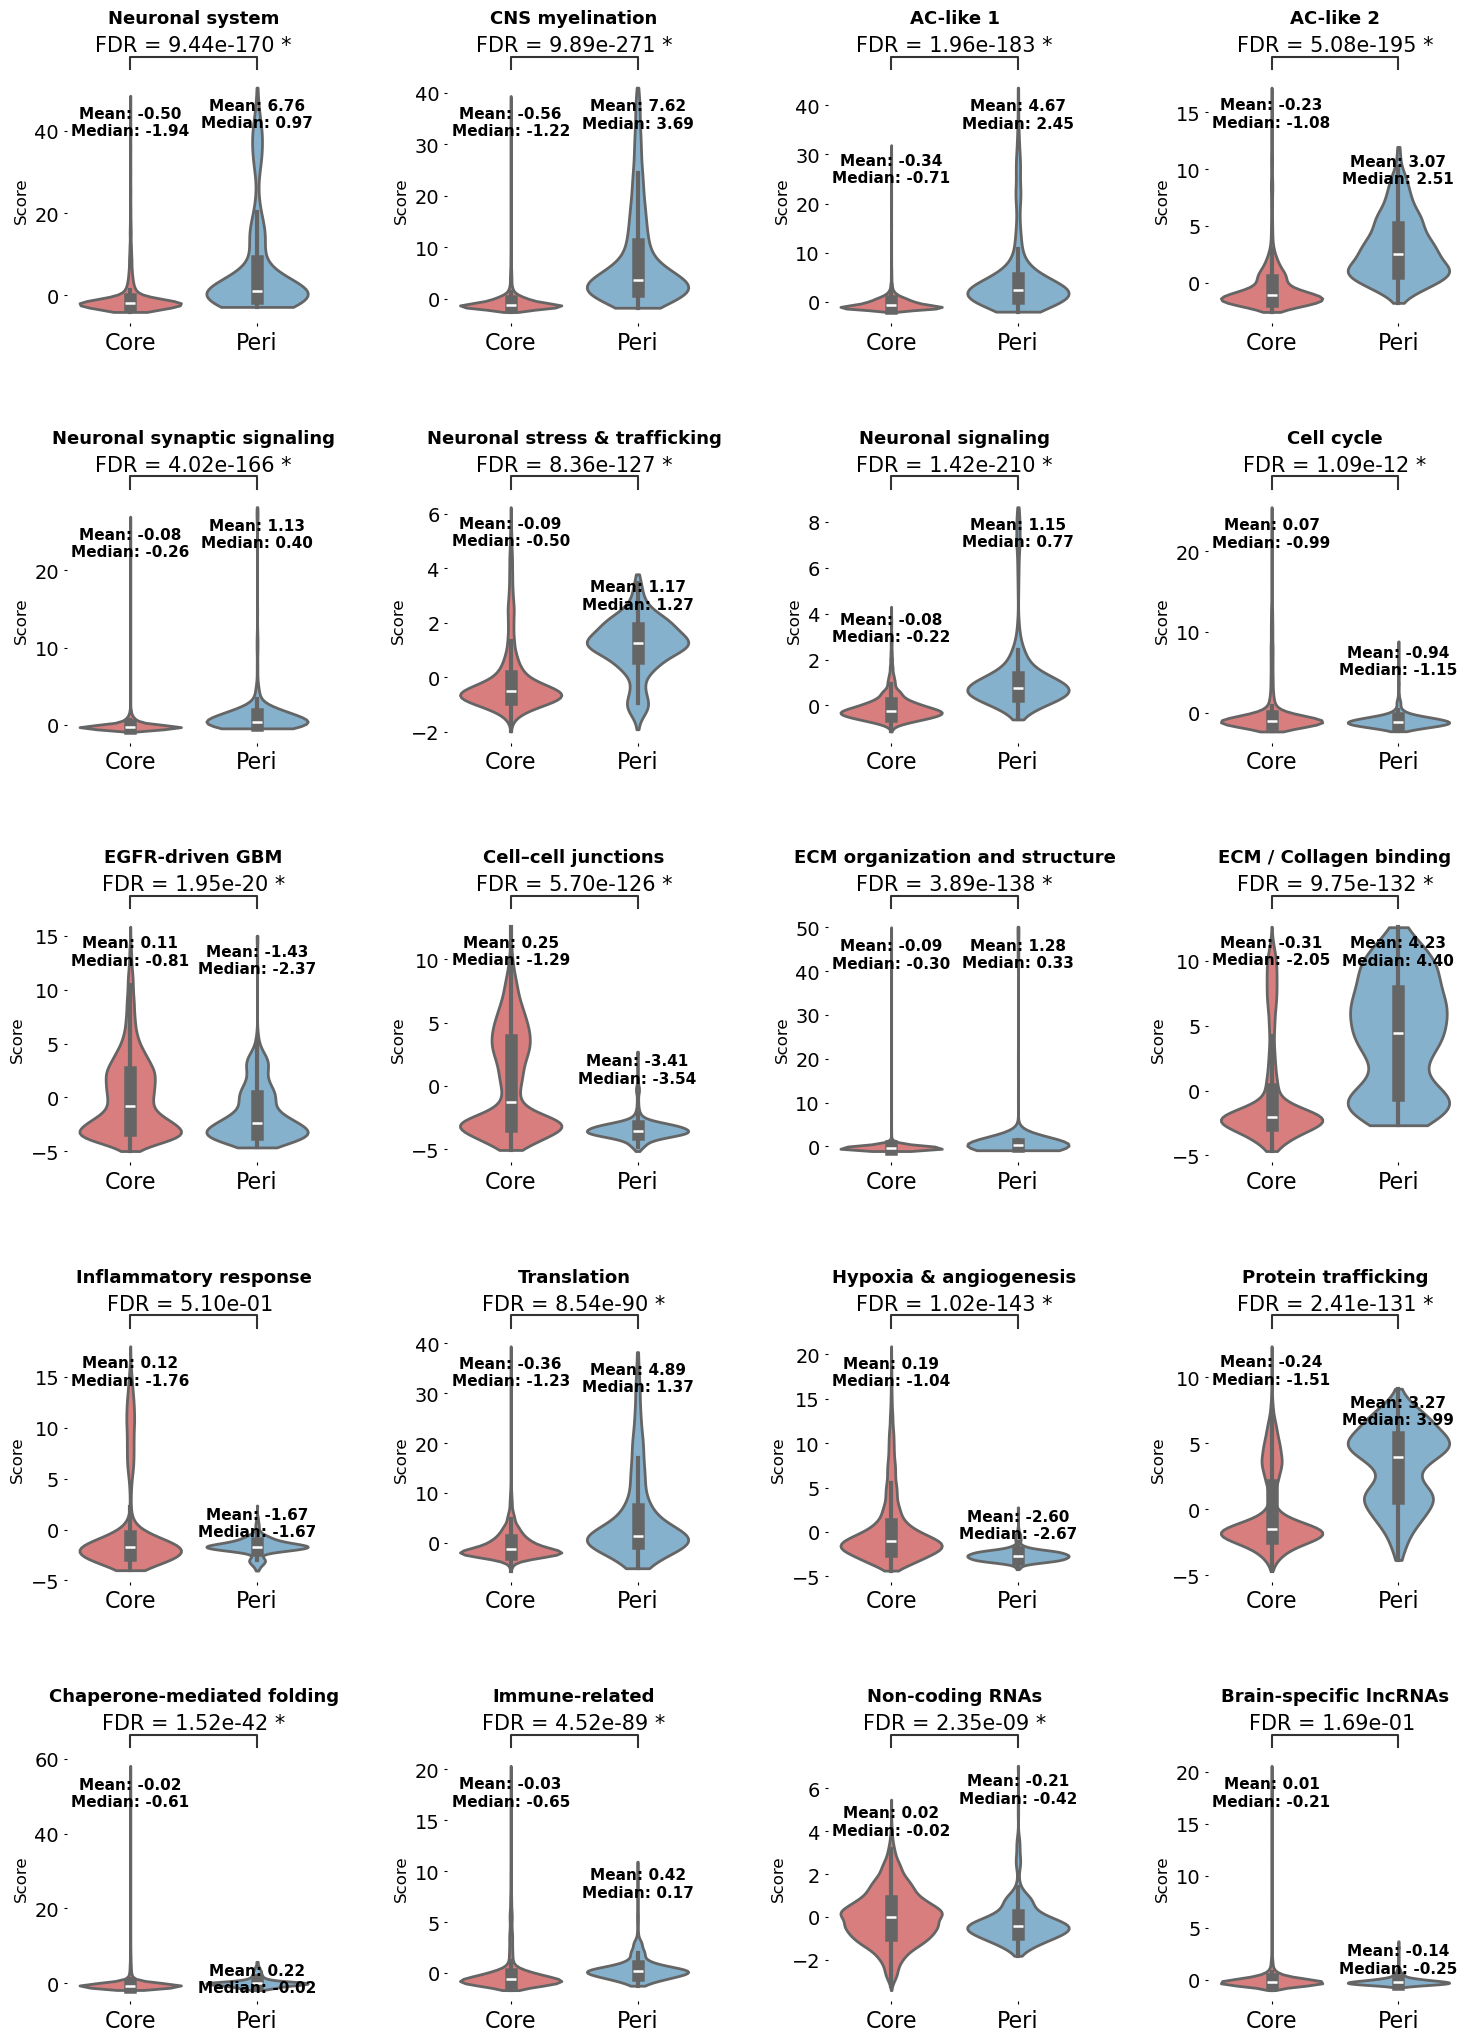

Plotted 20 modules: [1, 3, 8, 9, 16, 18, 19, 15, 7, 6, 14, 4, 5, 2, 10, 11, 13, 12, 17, 20]


In [43]:
# --- imports ---
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests  # FDR

# Optional: use statannotations if installed for pretty p-value bars
try:
    from statannotations.Annotator import Annotator
    HAS_ANNOTATOR = True
except Exception:
    HAS_ANNOTATOR = False

# ----------------- PARAMETERS YOU CAN EDIT -----------------
n_modules = 20                     # number of modules (columns 1..20)
order_sites = ["Core", "Peri"]     # order in violin plots
palette = {"Core": "#e76f6f", "Peri": "#79b4d9"}
ncols = 4
figsize_per_plot = (4.5, 5.0)
# -----------------------------------------------------------

# 0) Take module_scores and build a working DataFrame
#    module_scores: index = cell barcodes, columns = 1..20
df = module_scores.copy()

# Add "site" column based on cell name suffix (_Core / _Peri)
df["site"] = df.index.to_series().apply(
    lambda x: "Core" if x.endswith("Core") else
              ("Peri" if x.endswith("Peri") else np.nan)
)
df = df[df["site"].isin(order_sites)].copy()

# Module columns are assumed to be 1..20 (int or str)
module_cols = [c for c in df.columns if str(c).isdigit()]
module_cols = sorted(module_cols, key=lambda x: int(x))

print("Using module columns (original order):", module_cols)

# --------- CUSTOM PLOTTING ORDER (BY BIOLOGY) ---------
# 1) neural things
neural_mods = [1, 3, 8, 9, 16, 18, 19]
# 2) cell cycle + EGFR-driven GBM
cellcycle_egfr_mods = [15, 7,6]
# 3) ECM-related
ecm_mods = [14, 4, 5]
# 4) cellular stuff / trafficking
cellular_mods = [2, 10, 11, 13]
# 5) immune
immune_mods = [12]
# 6) non-coding
noncoding_mods = [17, 20]

desired_order_int = (
    neural_mods
    + cellcycle_egfr_mods
    + ecm_mods
    + cellular_mods
    + immune_mods
    + noncoding_mods
)

# map int -> actual column label (handles int or str)
int_to_col = {int(c): c for c in module_cols}
module_cols = [int_to_col[m] for m in desired_order_int if m in int_to_col]

print("Plotting modules in this order:", module_cols)


# ===========================================================
# 1) Compute raw p-values (Mann–Whitney) for all modules
# ===========================================================
raw_pvals = []
for m in module_cols:
    core_vals = df.loc[df["site"] == "Core", m].dropna()
    peri_vals = df.loc[df["site"] == "Peri", m].dropna()

    if len(core_vals) > 0 and len(peri_vals) > 0:
        stat, pval = stats.mannwhitneyu(core_vals, peri_vals, alternative='two-sided')
    else:
        pval = np.nan
    raw_pvals.append(pval)

# ===========================================================
# 2) FDR correction (Benjamini–Hochberg) across all modules
# ===========================================================
score_to_FDR = {}
score_to_signif = {}

valid_idx = [i for i, p in enumerate(raw_pvals) if not np.isnan(p)]
if len(valid_idx) > 0:
    valid_pvals = [raw_pvals[i] for i in valid_idx]
    rej, p_corr, _, _ = multipletests(valid_pvals, method='fdr_bh')

    for k, idx in enumerate(valid_idx):
        m = module_cols[idx]
        score_to_FDR[m] = p_corr[k]
        score_to_signif[m] = rej[k]

# ===========================================================
# 3) Plot grid and show FDR = ... with * if significant
# ===========================================================
nplots = len(module_cols)
nrows = math.ceil(nplots / ncols)
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)
)

if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = np.array([axes])

for i, m in enumerate(module_cols):
    ax = axes[i]

    # Violin plot
    sns.violinplot(
        data=df,
        x="site",
        y=m,
        order=order_sites,
        palette=palette,
        ax=ax,
        linewidth=2,
        cut=0
    )

    # Means/Max per site
    means = df.groupby("site")[m].mean().round(2)
    medians = df.groupby("site")[m].median().round(2)

    for j, site in enumerate(order_sites):
        site_vals = df.loc[df["site"] == site, m]
        y_top = site_vals.max() * 0.95  # place the label nicely

        ax.text(
        j, y_top,
        f"Mean: {means[site]:.2f}\nMedian: {medians[site]:.2f}",
        ha='center', va='top',
        fontsize=11, weight='bold'
    )


    # -------- Module title with pathway + top genes --------
    m_int = int(m)  # in case columns are strings
    title_text = module_names.get(m_int, f"Module {m_int}")

    ax.text(
        0.5, 1.2, title_text,
        fontsize=13,
        ha='center', va='bottom',
        transform=ax.transAxes,
        weight='bold'
    )

    # ----- FDR annotation -----
    corr_p = score_to_FDR.get(m, np.nan)
    signif = score_to_signif.get(m, False)
    if np.isnan(corr_p):
        fdr_text = "FDR = n/a"
    else:
        star = "*" if signif else ""
        fdr_text = f"FDR = {corr_p:.2e} {star}"

    if HAS_ANNOTATOR:
        pairs = [("Core", "Peri")]
        annotator = Annotator(
            ax, pairs,
            data=df,
            x="site",
            y=m,
            order=order_sites
        )
        annotator.configure(
            test=None,             # we already computed FDR
            text_format='simple',
            loc='outside',
            line_height=0.05,
            fontsize=15
        )
        annotator.set_custom_annotations([fdr_text])
        annotator.annotate()
    else:
        ax.text(
            0.5, 2, fdr_text,
            transform=ax.transAxes,
            ha='center', va='bottom',
            fontsize=11
        )

    # Axes styling
    ax.set_xlabel("")
    ax.set_ylabel("Score", fontsize=12)

    ax.tick_params(axis='x', length=2, labelsize=16)  # Core / Peri
    ax.tick_params(axis='y', length=2, labelsize=14)  # y-axis numbers

    for spine in ax.spines.values():
        spine.set_visible(False)

# Hide unused axes
for j in range(nplots, len(axes)):
    axes[j].set_visible(False)

# Adjust distances between subplots
fig.subplots_adjust(
    hspace=0.7,   # vertical space between rows
    wspace=0.5    # horizontal space between columns
)

plt.show()

print(f"Plotted {nplots} modules:", module_cols)


In [44]:
# peri low and high CNV

In [45]:
import scanpy as sc
tumor_cnv = sc.read("/scratch/fatemeh.nasrabadi/importsnt/THESIS_FINAL/10Samples/FINALIZED_GEX_INTEGRATED/TumorPerilabeledcnv.h5ad")

In [46]:
tumor_cnv.obs['cnv_raw_l2_high75']

AATCATCCATGTGGGA-1_BTROHT06_Peri    False
ACCCGTAAGAACCTAC-1_BTROHT06_Peri    False
AGTATAGCATTGTGTG-1_BTROHT06_Peri    False
ATATGCTCATCCCGCT-1_BTROHT06_Peri    False
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri    False
                                    ...  
TTTGGTGCAAGACTCC-1_BTROHT06_Core     <NA>
TTTGTCTAGAGAGCCG-1_BTROHT06_Core     <NA>
TTTGTGTTCCAATTAG-1_BTROHT06_Core     <NA>
TTTGTTGGTAATGACT-1_BTROHT06_Core     <NA>
TTTGTTGGTTCATCTA-1_BTROHT06_Core     <NA>
Name: cnv_raw_l2_high75, Length: 8121, dtype: boolean

In [47]:
# HOTSPOT analysis of all tumor cells (core + peri) revealed 20 modules in GBM cancer cells ( 7500 core 550 peri)

In [48]:
tumor_cnv.obs["cnv_raw_l2_high75"].value_counts(dropna=False)

cnv_raw_l2_high75
<NA>     7567
False     415
True      139
Name: count, dtype: Int64

In [49]:
import pandas as pd

# 1) Take the barcodes from tumor_cnv
barcodes = tumor_cnv.obs_names

# 2) Reindex module_scores on those barcodes
#    → rows in the same order as tumor_cnv, missing ones become NaN
module_scores_for_tumor = module_scores.reindex(barcodes)

# 3) Optionally rename columns if you want
module_scores_for_tumor.columns = [f"Module_{int(c)}" for c in module_scores_for_tumor.columns]

# 4) This is your new table
print(module_scores_for_tumor.head())


                                   Module_1  Module_2   Module_3  Module_4  \
AATCATCCATGTGGGA-1_BTROHT06_Peri   1.443171 -3.586384  14.740740  4.512987   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  -0.743586 -4.103982   3.246444  7.304844   
AGTATAGCATTGTGTG-1_BTROHT06_Peri  41.456902 -0.827937   9.224749 -1.460960   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  -1.440168  0.558769   4.350001  2.024365   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  -1.017943 -0.874249   0.339173  0.417180   

                                  Module_5  Module_6  Module_7  Module_8  \
AATCATCCATGTGGGA-1_BTROHT06_Peri -1.307571 -3.384105 -3.497232  0.691517   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri -1.351591 -3.800220 -2.722257  0.270490   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -3.029989 -3.788168  0.092761 -0.816182   
ATATGCTCATCCCGCT-1_BTROHT06_Peri -0.815776 -2.914601 -3.879433  1.036769   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri -1.012219 -1.769768 -0.140825 -0.391529   

                                  Module_9  Module_10  Module_11  Module_1

In [50]:
# 1) Get barcodes from tumor_cnv
barcodes = tumor_cnv.obs_names

# 2) Align module scores to the same barcodes
module_scores_for_tumor = module_scores.reindex(barcodes)

# 3) Extract CNV status
cnv_status = tumor_cnv.obs["cnv_raw_l2_high75"]

# 4) Combine into a single DataFrame
combined_table = module_scores_for_tumor.copy()
combined_table["cnv_raw_l2_high75"] = cnv_status.values

# 5) Show result
combined_table.head()


1         2          3         4  \
AATCATCCATGTGGGA-1_BTROHT06_Peri   1.443171 -3.586384  14.740740  4.512987   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  -0.743586 -4.103982   3.246444  7.304844   
AGTATAGCATTGTGTG-1_BTROHT06_Peri  41.456902 -0.827937   9.224749 -1.460960   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  -1.440168  0.558769   4.350001  2.024365   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  -1.017943 -0.874249   0.339173  0.417180   

                                         5         6         7         8  \
AATCATCCATGTGGGA-1_BTROHT06_Peri -1.307571 -3.384105 -3.497232  0.691517   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri -1.351591 -3.800220 -2.722257  0.270490   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -3.029989 -3.788168  0.092761 -0.816182   
ATATGCTCATCCCGCT-1_BTROHT06_Peri -0.815776 -2.914601 -3.879433  1.036769   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri -1.012219 -1.769768 -0.140825 -0.391529   

                                         9        10  ...        12        13  \
AATCATCCATGTGGGA-1_BTROHT06_Peri  6.931068 -3.376321  ...  0.733751 -1.435979   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri  6.502953 -3.275091  ...  0.314308 -1.295643   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -0.674308 -3.484411  ... -0.636608 -1.128988   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  0.601112 -0.320632  ...  2.867759 -0.053672   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  0.161809 -1.636317  ...  0.198644 -0.369935   

                                         14        15        16        17  \
AATCATCCATGTGGGA-1_BTROHT06_Peri   0.907483 -1.930760  1.714940  2.659619   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri   0.726737 -1.782945  1.242931  3.520266   
AGTATAGCATTGTGTG-1_BTROHT06_Peri   0.473656 -1.909679  4.471356  0.120682   
ATATGCTCATCCCGCT-1_BTROHT06_Peri  50.115695 -0.905679  0.800980  0.880385   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri  -0.132385 -0.113610  1.189091  7.048304   

                                        18        19        20  \
AATCATCCATGTGGGA-1_BTROHT06_Peri -0.966756  6.388129 -0.647587   
ACCCGTAAGAACCTAC-1_BTROHT06_Peri -0.799885  8.062720 -0.103738   
AGTATAGCATTGTGTG-1_BTROHT06_Peri -0.187647  0.306922 -0.400448   
ATATGCTCATCCCGCT-1_BTROHT06_Peri -0.308911 -0.291533  0.541017   
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri -0.235518  2.800299  0.528873   

                                  cnv_raw_l2_high75  
AATCATCCATGTGGGA-1_BTROHT06_Peri              False  
ACCCGTAAGAACCTAC-1_BTROHT06_Peri              False  
AGTATAGCATTGTGTG-1_BTROHT06_Peri              False  
ATATGCTCATCCCGCT-1_BTROHT06_Peri              False  
ATTTGTGAGCCTCTCG-1_BTROHT06_Peri              False  

[5 rows x 21 columns]

Plotting modules in this order: [1, 3, 8, 9, 16, 18, 19, 15, 7, 5, 10, 6, 14, 4, 2, 11, 13, 12, 17, 20]


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=9.13e-37*
P-H CNV vs. P-L CNV: FDR=5.58e-09*
Core vs. P-L CNV: FDR=9.35e-139*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=4.18e-75*
P-H CNV vs. P-L CNV: FDR=4.68e-01
Core vs. P-L CNV: FDR=8.80e-204*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.32e-72*
P-H CNV vs. P-L CNV: FDR=5.94e-09*
Core vs. P-L CNV: FDR=2.04e-120*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.23e-64*
P-H CNV vs. P-L CNV: FDR=7.57e-09*
Core vs. P-L CNV: FDR=7.07e-138*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=4.01e-29*
P-H CNV vs. P-L CNV: FDR=5.23e-12*
Core vs. P-L CNV: FDR=7.11e-144*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=7.31e-46*
P-H CNV vs. P-L CNV: FDR=2.77e-05*
Core vs. P-L CNV: FDR=1.09e-86*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=7.35e-61*
P-H CNV vs. P-L CNV: FDR=2.10e-01
Core vs. P-L CNV: FDR=1.86e-156*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=3.03e-04*
P-H CNV vs. P-L CNV: FDR=9.27e-01
Core vs. P-L CNV: FDR=8.02e-10*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=2.62e-18*
P-H CNV vs. P-L CNV: FDR=6.29e-08*
Core vs. P-L CNV: FDR=9.03e-09*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=2.49e-02*
P-H CNV vs. P-L CNV: FDR=8.67e-03*
Core vs. P-L CNV: FDR=6.10e-01


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.04e-40*
P-H CNV vs. P-L CNV: FDR=6.10e-01
Core vs. P-L CNV: FDR=7.10e-108*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=3.88e-42*
P-H CNV vs. P-L CNV: FDR=1.30e-04*
Core vs. P-L CNV: FDR=8.74e-89*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=8.68e-42*
P-H CNV vs. P-L CNV: FDR=5.54e-01
Core vs. P-L CNV: FDR=2.91e-101*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=8.47e-52*
P-H CNV vs. P-L CNV: FDR=1.66e-11*
Core vs. P-L CNV: FDR=6.74e-87*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=5.12e-31*
P-H CNV vs. P-L CNV: FDR=6.18e-02
Core vs. P-L CNV: FDR=6.91e-63*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.32e-56*
P-H CNV vs. P-L CNV: FDR=6.69e-16*
Core vs. P-L CNV: FDR=4.13e-83*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.49e-28*
P-H CNV vs. P-L CNV: FDR=7.32e-08*
Core vs. P-L CNV: FDR=1.36e-21*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=1.97e-33*
P-H CNV vs. P-L CNV: FDR=5.13e-02
Core vs. P-L CNV: FDR=2.80e-60*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=7.96e-06*
P-H CNV vs. P-L CNV: FDR=1.29e-02*
Core vs. P-L CNV: FDR=1.53e-05*


/tmp/ipykernel_598157/703450157.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


Core vs. P-H CNV: FDR=4.91e-03*
P-H CNV vs. P-L CNV: FDR=4.91e-03*
Core vs. P-L CNV: FDR=9.93e-01


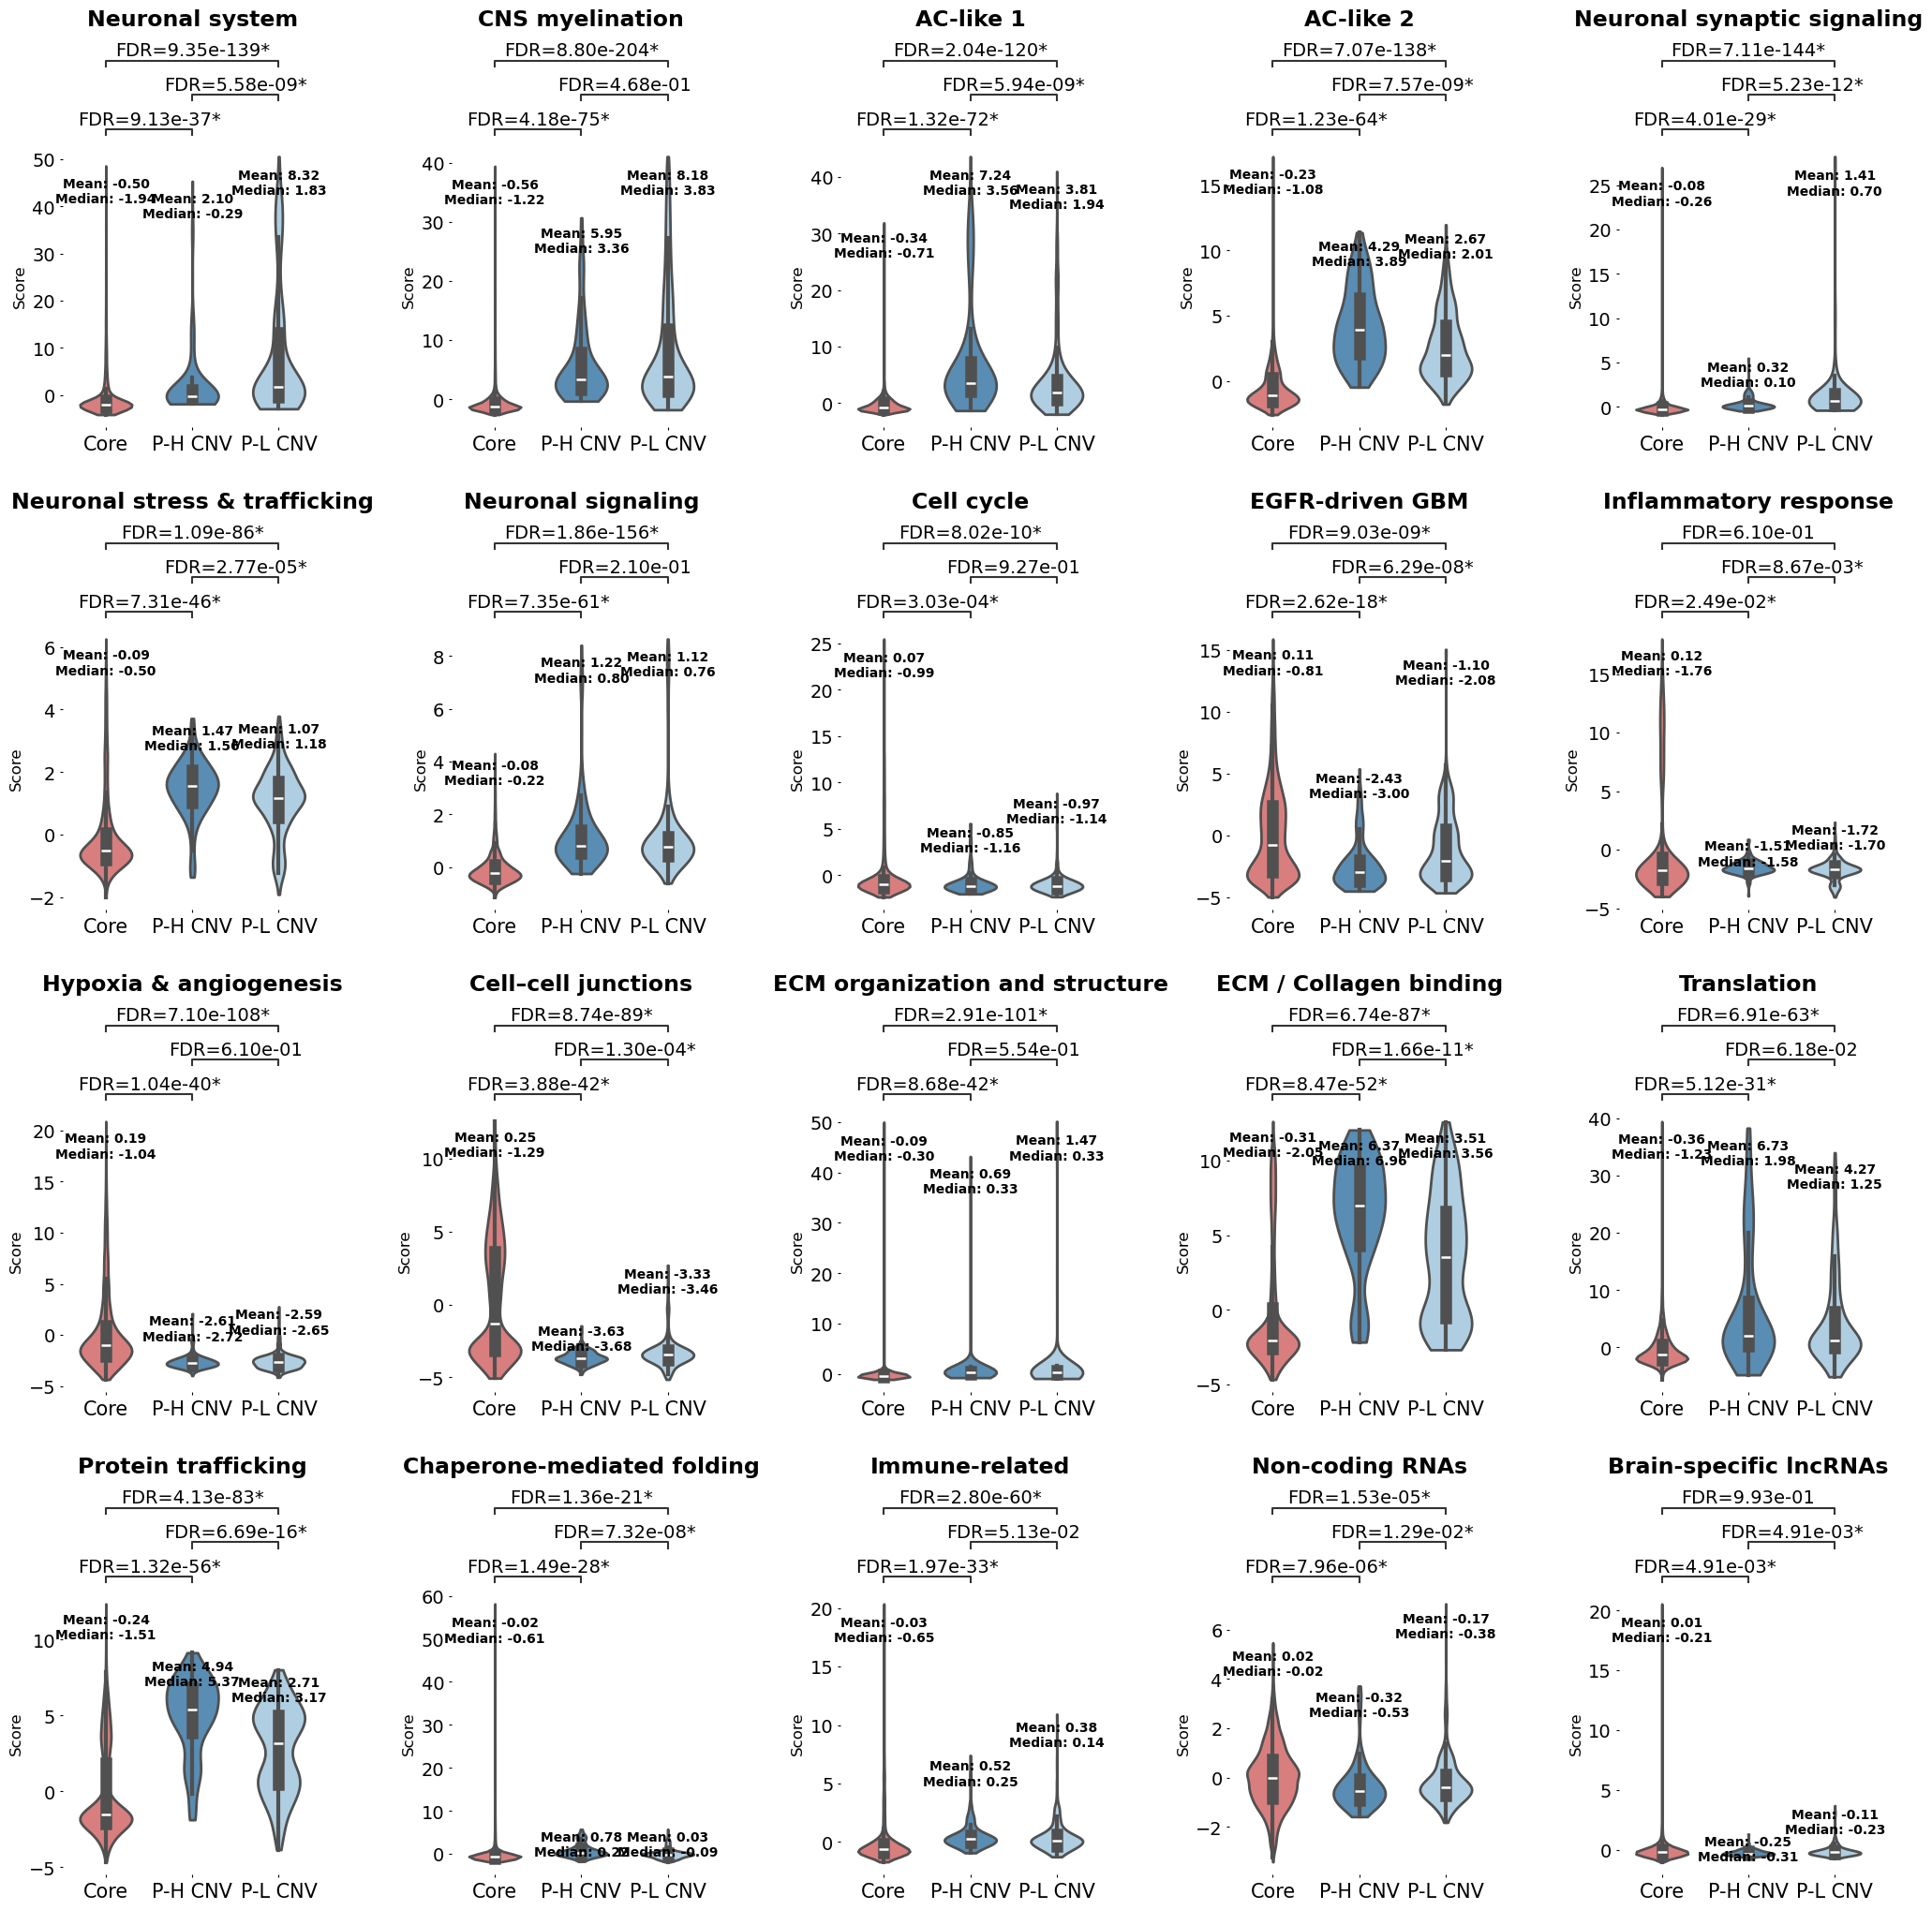

Plotted 20 modules: [1, 3, 8, 9, 16, 18, 19, 15, 7, 5, 10, 6, 14, 4, 2, 11, 13, 12, 17, 20]


In [51]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests  # FDR

# Optional: statannotations
try:
    from statannotations.Annotator import Annotator
    HAS_ANNOTATOR = True
except Exception:
    HAS_ANNOTATOR = False

# --- MODULE TITLES (keyed by module number, in biological groups) ---

module_names = {
    1:  "Neuronal system",
    2:  "Translation",
    3:  "CNS myelination",
    4:  "ECM / Collagen binding",
    5:  "Inflammatory response",
    6:  "Cell–cell junctions",
    7:  "EGFR-driven GBM",
    8:  "AC-like 1",
    9:  "AC-like 2",
    10: "Hypoxia & angiogenesis",
    11: "Protein trafficking",
    12: "Immune-related",
    13: "Chaperone-mediated folding",
    14: "ECM organization and structure",
    15: "Cell cycle",
    16: "Neuronal synaptic signaling",
    17: "Non-coding RNAs",
    18: "Neuronal stress & trafficking",
    19: "Neuronal signaling",
    20: "Brain-specific lncRNAs"
}


# ================== PREPARE DATA ==================
df = combined_table.copy()

# Make 3 groups based on cnv_raw_l2_high75
def cnv_group(val):
    if pd.isna(val):
        return "Core"
    return "P-H CNV" if val else "P-L CNV"  # Changed labels here

df["group"] = df["cnv_raw_l2_high75"].apply(cnv_group)

group_order = ["Core", "P-H CNV", "P-L CNV"]  # Updated group labels

palette = {
    "Core": "#e76f6f",
    "P-L CNV": "#A6D0EA",  # Lighter blue
    "P-H CNV": "#4A90C2"   # Darker blue
}


# --------- CUSTOM PLOTTING ORDER (BY BIOLOGY) ---------
# 1) neural things
neural_mods = [1, 3, 8, 9, 16, 18, 19]
# 2) cell cycle + EGFR-driven GBM
cellcycle_egfr_mods = [15, 7, 5, 10, 6]
# 3) ECM-related
ecm_mods = [14, 4]
# 4) cellular stuff / trafficking
cellular_mods = [2, 11, 13]
# 5) immune
immune_mods = [12]
# 6) non-coding
noncoding_mods = [17, 20]

desired_order_int = (
    neural_mods
    + cellcycle_egfr_mods
    + ecm_mods
    + cellular_mods
    + immune_mods
    + noncoding_mods
)

# map int -> actual column label (handles int or str)
int_to_col = {int(c): c for c in module_cols}
module_cols = [int_to_col[m] for m in desired_order_int if m in int_to_col]

print("Plotting modules in this order:", module_cols)


# ================== STATISTICS ==================
pairs = [
    ("Core", "P-L CNV"),  # Updated labels
    ("Core", "P-H CNV"),  # Updated labels
    ("P-L CNV", "P-H CNV")  # Updated labels
]

raw_pvals = {}
for m in module_cols:
    for pair in pairs:
        g1, g2 = pair
        v1 = df.loc[df["group"] == g1, m].dropna()
        v2 = df.loc[df["group"] == g2, m].dropna()
        if len(v1) > 0 and len(v2) > 0:
            stat, p = stats.mannwhitneyu(v1, v2, alternative="two-sided")
        else:
            p = np.nan
        raw_pvals[(m, pair)] = p

# FDR correction across ALL tests
valid_keys = [k for k, p in raw_pvals.items() if not np.isnan(p)]
valid_pvals = [raw_pvals[k] for k in valid_keys]

rej, p_corr, _, _ = multipletests(valid_pvals, method="fdr_bh")

fdr_dict = {}
sig_dict = {}
for k, corr_p, r in zip(valid_keys, p_corr, rej):
    fdr_dict[k] = corr_p
    sig_dict[k] = r

# ================== PLOTTING (appearance tuned) ==================
ncols = 5
figsize_per_plot = (5, 6)
nplots = len(module_cols)
nrows = math.ceil(nplots / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)
)

if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = np.array([axes])

for i, m in enumerate(module_cols):
    ax = axes[i]
    sns.violinplot(
        data=df,
        x="group",
        y=m,
        order=group_order,
        palette=palette,
        ax=ax,
        linewidth=2,
        width=0.6,
        cut=0,
        dodge=False
    )

    # Explicitly set the x-ticks and their labels with larger font size
    ax.set_xticks(range(len(group_order)))  # Set tick positions explicitly
    ax.set_xticklabels(group_order, fontsize=16)  # Set the font size of labels directly
    ax.tick_params(axis='x', labelsize=16)  # Ensure font size for x-axis tick labels is also updated

    # Mean & median per group
    means = df.groupby("group")[m].mean().round(2)
    medians = df.groupby("group")[m].median().round(2)

    for j, g in enumerate(group_order):
        vals = df.loc[df["group"] == g, m]
        if len(vals) == 0:
            continue
        y_top = vals.max() * 0.95

        ax.text(
            j, y_top,
            f"Mean: {means[g]:.2f}\nMedian: {medians[g]:.2f}",
            ha="center", va="top",
            fontsize=10,
            weight="bold"
        )

    # ----- Title with module name -----
    m_int = int(m)
    title_text = module_names.get(m_int, f"Module {m_int}")
    ax.text(
        0.5, 1.4, title_text,
        fontsize=17,
        ha="center", va="bottom",
        transform=ax.transAxes,
        weight="bold"
    )

    # ----- FDR annotation (3 pairwise comparisons) -----
    if HAS_ANNOTATOR:
        pairs_here = pairs
        annots = []
        for pair in pairs_here:
            key = (m, pair)
            if key in fdr_dict:
                f = fdr_dict[key]
                star = "*" if sig_dict.get(key, False) else ""
                annots.append(f"FDR={f:.2e}{star}")
            else:
                annots.append("FDR=n/a")

        annotator = Annotator(
            ax, pairs_here,
            data=df, x="group", y=m,
            order=group_order
        )
        annotator.configure(
            test=None,
            text_format="simple",
            loc="outside",
            line_height=0.02,
            fontsize=14
        )
        annotator.set_custom_annotations(annots)
        annotator.annotate()
    else:
        text_lines = []
        for pair in pairs:
            key = (m, pair)
            if key in fdr_dict:
                f = fdr_dict[key]
                star = "*" if sig_dict.get(key, False) else ""
                text_lines.append(f"{pair[0]} vs {pair[1]}: {f:.2e}{star}")
        ax.text(
            0.4, 2.0,
            "\n".join(text_lines),
            transform=ax.transAxes,
            ha="center", va="bottom",
            fontsize=11
        )

    # Axes styling
    ax.set_xlabel("")
    ax.set_ylabel("Score", fontsize=12)
    ax.tick_params(axis='x', length=2, labelsize=15)
    ax.tick_params(axis='y', length=2, labelsize=14)

    for spine in ax.spines.values():
        spine.set_visible(False)

# Hide unused axes
for j in range(nplots, len(axes)):
    axes[j].set_visible(False)

fig.subplots_adjust(
    hspace=0.7,
    wspace=0.5
)

plt.show()
print(f"Plotted {nplots} modules:", module_cols)


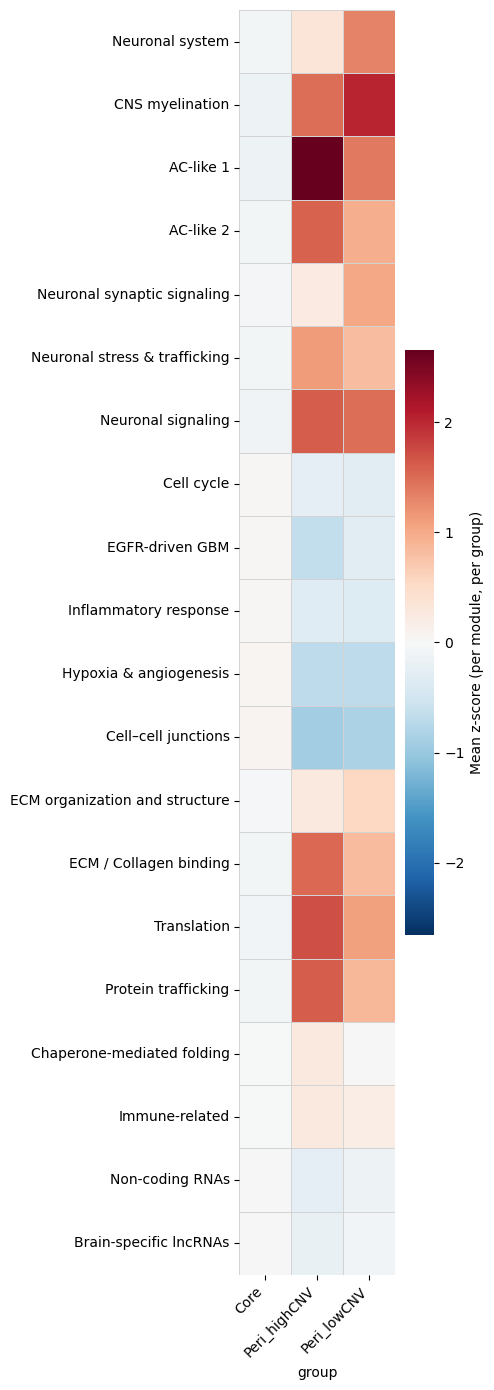

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0) شروع از جدول سلول‌ها ----------
# combined_table: index = barcodes
# columns = 1..20 (module scores) + 'cnv_raw_l2_high75'
df = combined_table.copy()

# ستون گروه را بسازیم از روی cnv_raw_l2_high75
def cnv_to_group(val):
    if pd.isna(val):
        return "Core"          # NaN = core
    return "Peri_highCNV" if val else "Peri_lowCNV"

df["group"] = df["cnv_raw_l2_high75"].apply(cnv_to_group)

# ترتیب گروه‌ها روی هیت‌مپ
group_order = ["Core", "Peri_highCNV" ,"Peri_lowCNV"]

# فقط ۲۰ ماژول عددی را برداریم (در صورت نیاز)
module_cols_all = [c for c in df.columns if str(c).isdigit()]
module_cols_all = sorted(module_cols_all, key=lambda x: int(x))

# --------- CUSTOM ORDER (BY BIOLOGY) ---------
# 1) neural things
neural_mods = [1, 3, 8, 9, 16, 18, 19]
# 2) cell cycle + EGFR-driven GBM (+ 5,10 per your code)
cellcycle_egfr_mods = [15, 7, 5, 10,6]
# 3) ECM-related
ecm_mods = [14, 4]
# 4) cellular stuff / trafficking
cellular_mods = [2, 11, 13]
# 5) immune
immune_mods = [12]
# 6) non-coding
noncoding_mods = [17, 20]

desired_order_int = (
    neural_mods
    + cellcycle_egfr_mods
    + ecm_mods
    + cellular_mods
    + immune_mods
    + noncoding_mods
)

# we will use this list as the selected modules
selected_modules = desired_order_int

# IMPORTANT: override module_cols to follow your custom order
module_cols = selected_modules

# ---------- 1) تعریف نام کوتاه ماژول‌ها ----------
module_names_short  = {
    1:  "Neuronal system",
    2:  "Translation",
    3:  "CNS myelination",
    4:  "ECM / Collagen binding",
    5:  "Inflammatory response",
    6:  "Cell–cell junctions",
    7:  "EGFR-driven GBM",
    8:  "AC-like 1",
    9:  "AC-like 2",
    10: "Hypoxia & angiogenesis",
    11: "Protein trafficking",
    12: "Immune-related",
    13: "Chaperone-mediated folding",
    14: "ECM organization and structure",
    15: "Cell cycle",
    16: "Neuronal synaptic signaling",
    17: "Non-coding RNAs",
    18: "Neuronal stress & trafficking",
    19: "Neuronal signaling",
    20: "Brain-specific lncRNAs"
}

# ---------- 2) z-score روی همه‌ی سلول‌ها برای هر ماژول ----------
scores = df[module_cols]  # سلول × ماژول (به ترتیب دلخواه)

# z-score ستونی: برای هر ماژول روی همه‌ی سلول‌ها
scores_z = (scores - scores.mean(axis=0)) / scores.std(axis=0)

# این Z ها را دوباره همراه با group نگه می‌داریم
df_z = scores_z.copy()
df_z["group"] = df["group"]

# ---------- 3) میانگین z-score هر گروه برای هر ماژول ----------
mean_z_by_group = (
    df_z.groupby("group")[module_cols]
        .mean()               # میانگین در سلول‌های هر گروه
        .T                    # سطر = ماژول، ستون = گروه
)

# ستون‌ها را به ترتیب دلخواه بچین
mean_z_by_group = mean_z_by_group[group_order]

# برچسب سطرها: اسم ماژول‌ها
row_labels = [
    module_names_short.get(int(m), f"Module {m}")
    for m in mean_z_by_group.index
]
mean_z_by_group.index = row_labels

# ---------- 4) رسم هیت‌مپ ----------
plt.figure(figsize=(5, 0.6 * len(module_cols) + 2))

vmax = np.nanmax(np.abs(mean_z_by_group.values))

sns.heatmap(
    mean_z_by_group,
    cmap="RdBu_r",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    linewidths=0.5,
    linecolor="lightgrey",
    xticklabels=mean_z_by_group.columns,
    yticklabels=mean_z_by_group.index,
    cbar_kws={"label": "Mean z-score (per module, per group)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


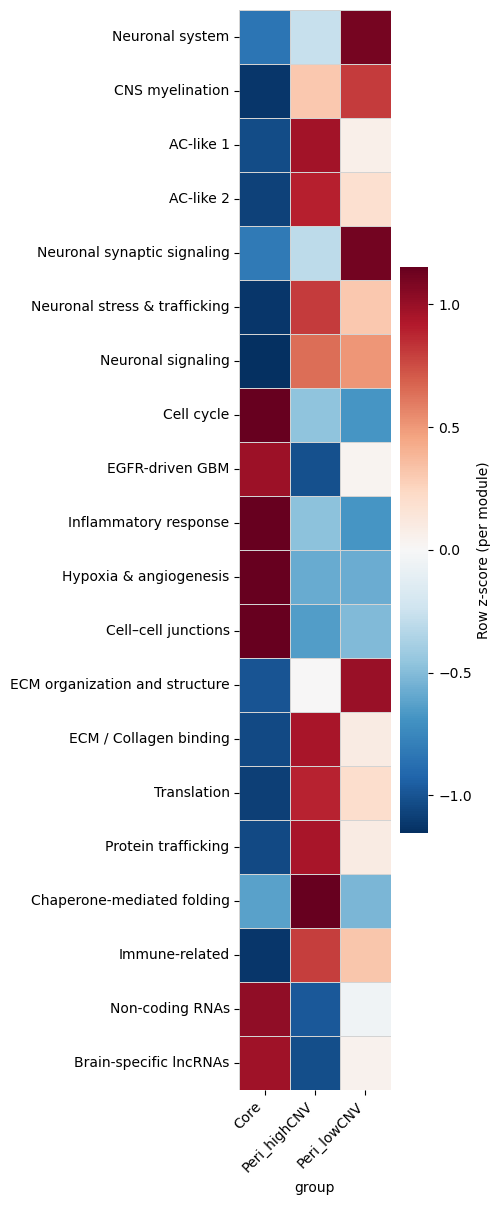

In [53]:
row_means = mean_z_by_group.mean(axis=1)
row_stds  = mean_z_by_group.std(axis=1).replace(0, np.nan)

mean_z_row = mean_z_by_group.sub(row_means, axis=0).div(row_stds, axis=0)

plt.figure(figsize=(5, 0.6 * len(module_cols) + 0.15))

vmax = np.nanmax(np.abs(mean_z_row.values))

sns.heatmap(
    mean_z_row,
    cmap="RdBu_r",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    linewidths=0.5,
    linecolor="lightgrey",
    xticklabels=mean_z_row.columns,
    yticklabels=mean_z_row.index,
    cbar_kws={"label": "Row z-score (per module)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [54]:
module_names_short  = {
    1:  "Neuronal system",
    2:  "Translation",
    3:  "CNS myelination",
    4:  "ECM / Collagen binding",
    5:  "Inflammatory response",
    6:  "Cell–cell junctions",
    7:  "EGFR-driven GBM",
    8:  "AC-like 1",
    9:  "AC-like 2",
    10: "Hypoxia & angiogenesis",
    11: "Protein trafficking",
    12: "Immune-related",
    13: "Chaperone-mediated folding",
    14: "ECM organization and structure",
    15: "Cell cycle",
    16: "Neuronal synaptic signaling",
    17: "Non-coding RNAs",
    18: "Neuronal stress & trafficking",
    19: "Neuronal signaling",
    20: "Brain-specific lncRNAs"
}

# No * for these:
star_excluded = {"Inflammatory response", "Non-coding RNAs"}

# No † for these:
dagger_excluded = {
    "Immune-related",
    "Hypoxia & angiogenesis",
    "CNS myelination",
    "Neuronal signaling",
    "Cell cycle",
}

module_names_plot = {}
for k, v in module_names_short.items():
    label = v
    if v not in star_excluded:
        label += " *"
    if v not in dagger_excluded:
        label += " †"
    module_names_plot[k] = label


/tmp/ipykernel_598157/1822252829.py:101: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


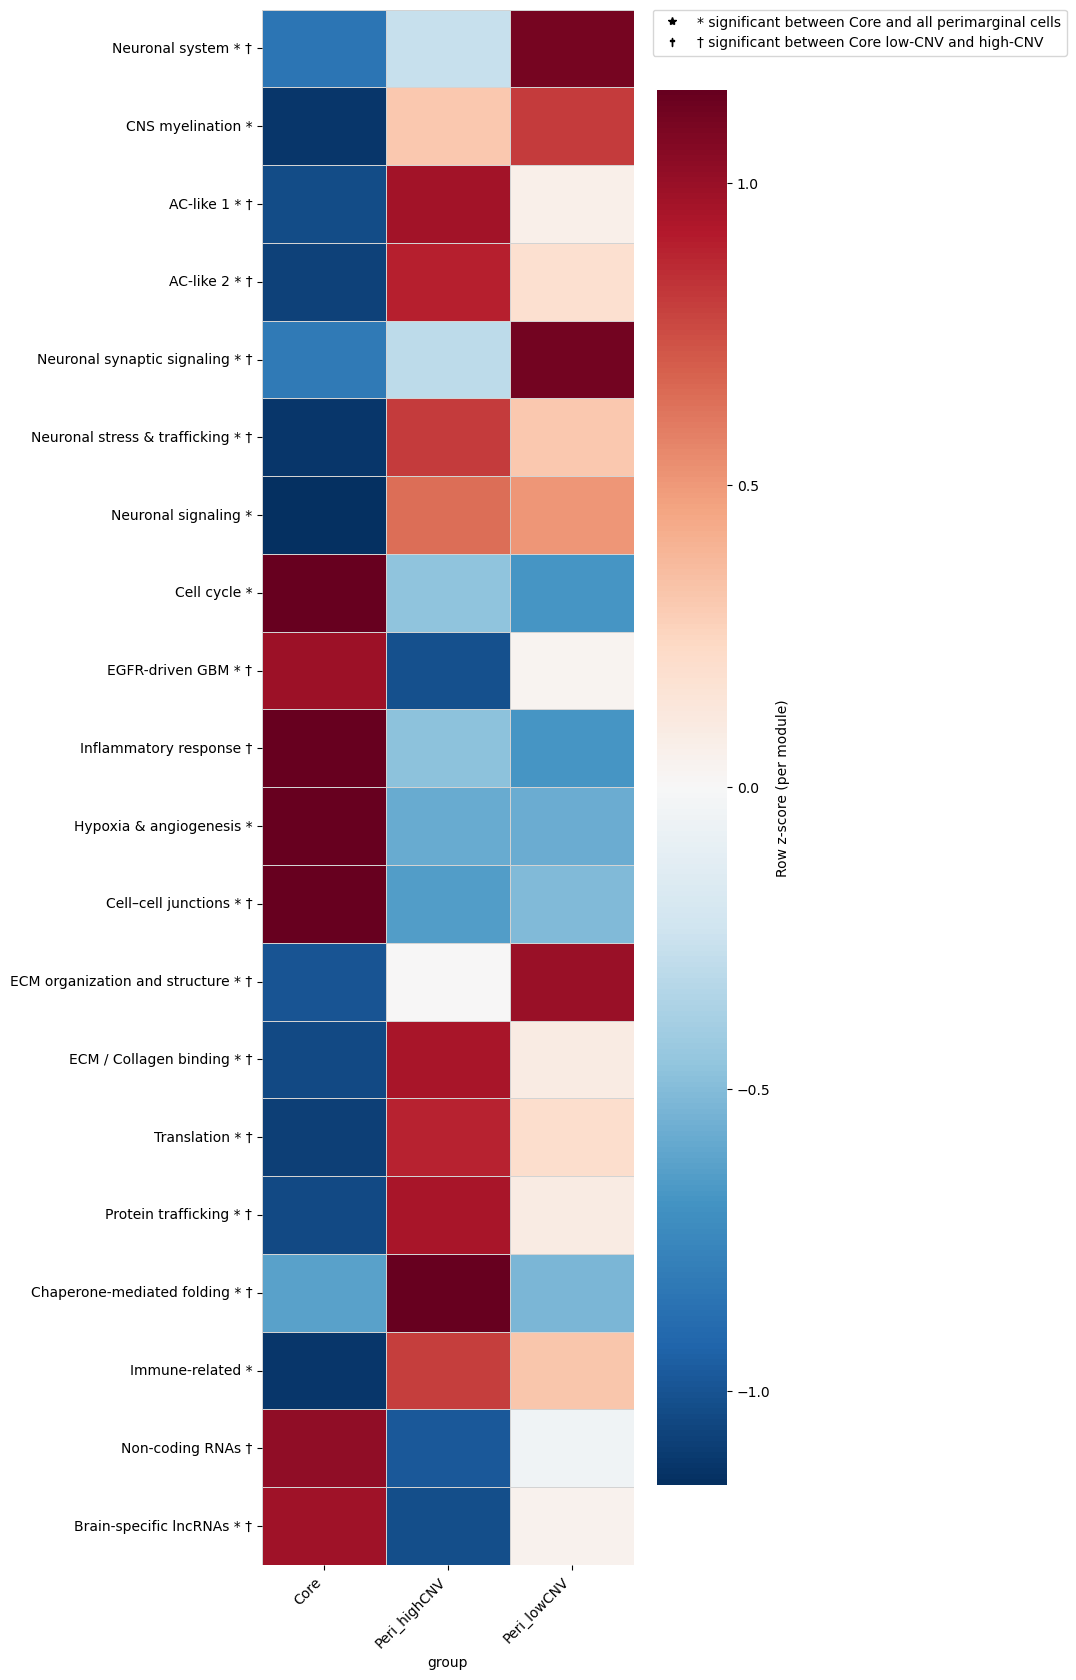

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# --- Your module base names (by integer ID) ---
module_names_short  = {
    1:  "Neuronal system",
    2:  "Translation",
    3:  "CNS myelination",
    4:  "ECM / Collagen binding",
    5:  "Inflammatory response",
    6:  "Cell–cell junctions",
    7:  "EGFR-driven GBM",
    8:  "AC-like 1",
    9:  "AC-like 2",
    10: "Hypoxia & angiogenesis",
    11: "Protein trafficking",
    12: "Immune-related",
    13: "Chaperone-mediated folding",
    14: "ECM organization and structure",
    15: "Cell cycle",
    16: "Neuronal synaptic signaling",
    17: "Non-coding RNAs",
    18: "Neuronal stress & trafficking",
    19: "Neuronal signaling",
    20: "Brain-specific lncRNAs"
}

# --- Which ones do NOT get * and † ---
star_excluded = {"Inflammatory response", "Non-coding RNAs"}
dagger_excluded = {
    "Immune-related",
    "Hypoxia & angiogenesis",
    "CNS myelination",
    "Neuronal signaling",
    "Cell cycle",
}

# --- Build labels that match your actual row index ---
module_names_plot = {}

for m in mean_z_by_group.index:      # use whatever is really in the DF
    base = module_names_short.get(m, str(m))   # fall back to the raw index if missing

    label = base
    if base not in star_excluded:
        label += " *"
    if base not in dagger_excluded:
        label += " †"

    module_names_plot[m] = label

# --- Z-score per row ---
row_means = mean_z_by_group.mean(axis=1)
row_stds  = mean_z_by_group.std(axis=1).replace(0, np.nan)
mean_z_row = mean_z_by_group.sub(row_means, axis=0).div(row_stds, axis=0)

# Use the annotated labels as index
mean_z_row = mean_z_row.copy()
mean_z_row.index = [module_names_plot.get(m, str(m)) for m in mean_z_row.index]

# --- Plot ---
plt.figure(figsize=(6, 1 * len(mean_z_row) + 0.20))

vmax = np.nanmax(np.abs(mean_z_row.values))

ax = sns.heatmap(
    mean_z_row,
    cmap="RdBu_r",
    center=0,
    vmin=-vmax,
    vmax=vmax,
    linewidths=0.5,
    linecolor="lightgrey",
    xticklabels=mean_z_row.columns,
    yticklabels=mean_z_row.index,
    cbar_kws={"label": "Row z-score (per module)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# --- Legend explaining symbols ---
star_handle = mlines.Line2D(
    [], [], color="black", marker="*", linestyle="None",
    label="* significant between Core and all perimarginal cells"
)
dagger_handle = mlines.Line2D(
    [], [], color="black", marker=r'$\dagger$', linestyle="None",
    label="† significant between Core low-CNV and high-CNV"
)

ax.legend(
    handles=[star_handle, dagger_handle],
    loc="upper left",
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.
)

plt.tight_layout()
plt.show()
